In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

device

device(type='mps')

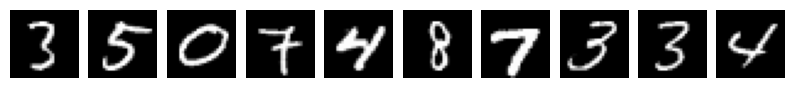

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid


def show_images(images, n=10):
    fig = plt.figure(figsize=(10.0, 10.0))
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(1, n),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )
    for i in range(n):
        grid[i].imshow(images[i].squeeze().cpu().numpy(), cmap="gray")
        grid[i].axis("off")
    plt.show()


show_images(next(iter(train_loader))[0], 10)

In [8]:
class VAE(nn.Module):
    def __init__(
        self, input_dim=28 * 28, hidden_dim=400, latent_dim=200, device=device
    ):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU(),
        )
        self.mu = nn.Linear(latent_dim, 2)
        self.logvar = nn.Linear(latent_dim, 2)
        self.decoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        self.device = device

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [9]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
def vae_loss(x, x_hat, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 28 * 28), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [11]:
def training_loop(model, optimizer, train_loader, epochs=100):
    model.train()
    losses = []
    for epoch in range(epochs):
        for x, _ in train_loader:
            optimizer.zero_grad()
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            loss = vae_loss(x, x_hat, mu, logvar)
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
    return model, losses

In [12]:
model, losses = training_loop(model, optimizer, train_loader)

Epoch: 0, Loss: 16030.8759765625
Epoch: 1, Loss: 14390.5390625
Epoch: 2, Loss: 14887.90625
Epoch: 3, Loss: 14888.064453125
Epoch: 4, Loss: 13243.833984375
Epoch: 5, Loss: 15039.9873046875
Epoch: 6, Loss: 14623.2197265625
Epoch: 7, Loss: 14843.783203125
Epoch: 8, Loss: 14590.71875
Epoch: 9, Loss: 13788.8720703125
Epoch: 10, Loss: 13907.0498046875
Epoch: 11, Loss: 13885.505859375
Epoch: 12, Loss: 14140.4990234375
Epoch: 13, Loss: 13236.0302734375
Epoch: 14, Loss: 15061.3984375
Epoch: 15, Loss: 13278.3515625
Epoch: 16, Loss: 13427.56640625
Epoch: 17, Loss: 14167.2412109375
Epoch: 18, Loss: 13364.62890625
Epoch: 19, Loss: 13751.5419921875
Epoch: 20, Loss: 13947.939453125
Epoch: 21, Loss: 13831.7138671875
Epoch: 22, Loss: 14534.0595703125
Epoch: 23, Loss: 12592.55859375
Epoch: 24, Loss: 13569.3837890625
Epoch: 25, Loss: 12668.7490234375
Epoch: 26, Loss: 13340.076171875
Epoch: 27, Loss: 13659.671875
Epoch: 28, Loss: 13351.3037109375
Epoch: 29, Loss: 13166.7001953125
Epoch: 30, Loss: 13267.43

In [13]:
def generate(mean, var):
    sample_z = torch.tensor([mean, var]).float().to(device)
    with torch.no_grad():
        sample = model.decoder(sample_z).view(28, 28)
        sample = sample.detach().cpu().numpy()
    plt.imshow(sample, cmap="gray")
    plt.axis("off")
    plt.show()

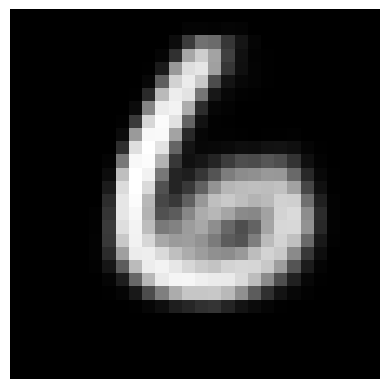

In [14]:
generate(0, 1)

In [17]:
def generate_n_samples_in_grid(model, n_samples=25):
    with torch.no_grad():
        z = torch.randn(n_samples, 2).to(device)
        samples = model.decoder(z).view(-1, 28, 28)
    grid = ImageGrid(
        plt.figure(figsize=(10.0, 10.0)),
        111,
        nrows_ncols=(5, 5),
        axes_pad=0.1,
    )
    for i, ax in enumerate(grid):
        ax.imshow(samples[i].cpu().numpy(), cmap="gray")
        ax.axis("off")
    plt.show()
    

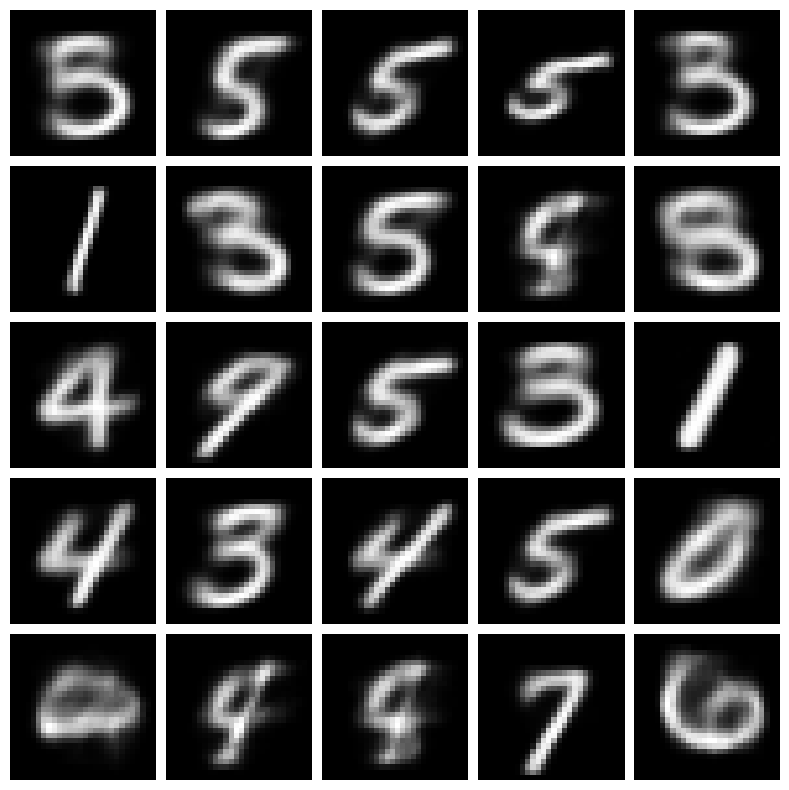

In [18]:
generate_n_samples_in_grid(model)

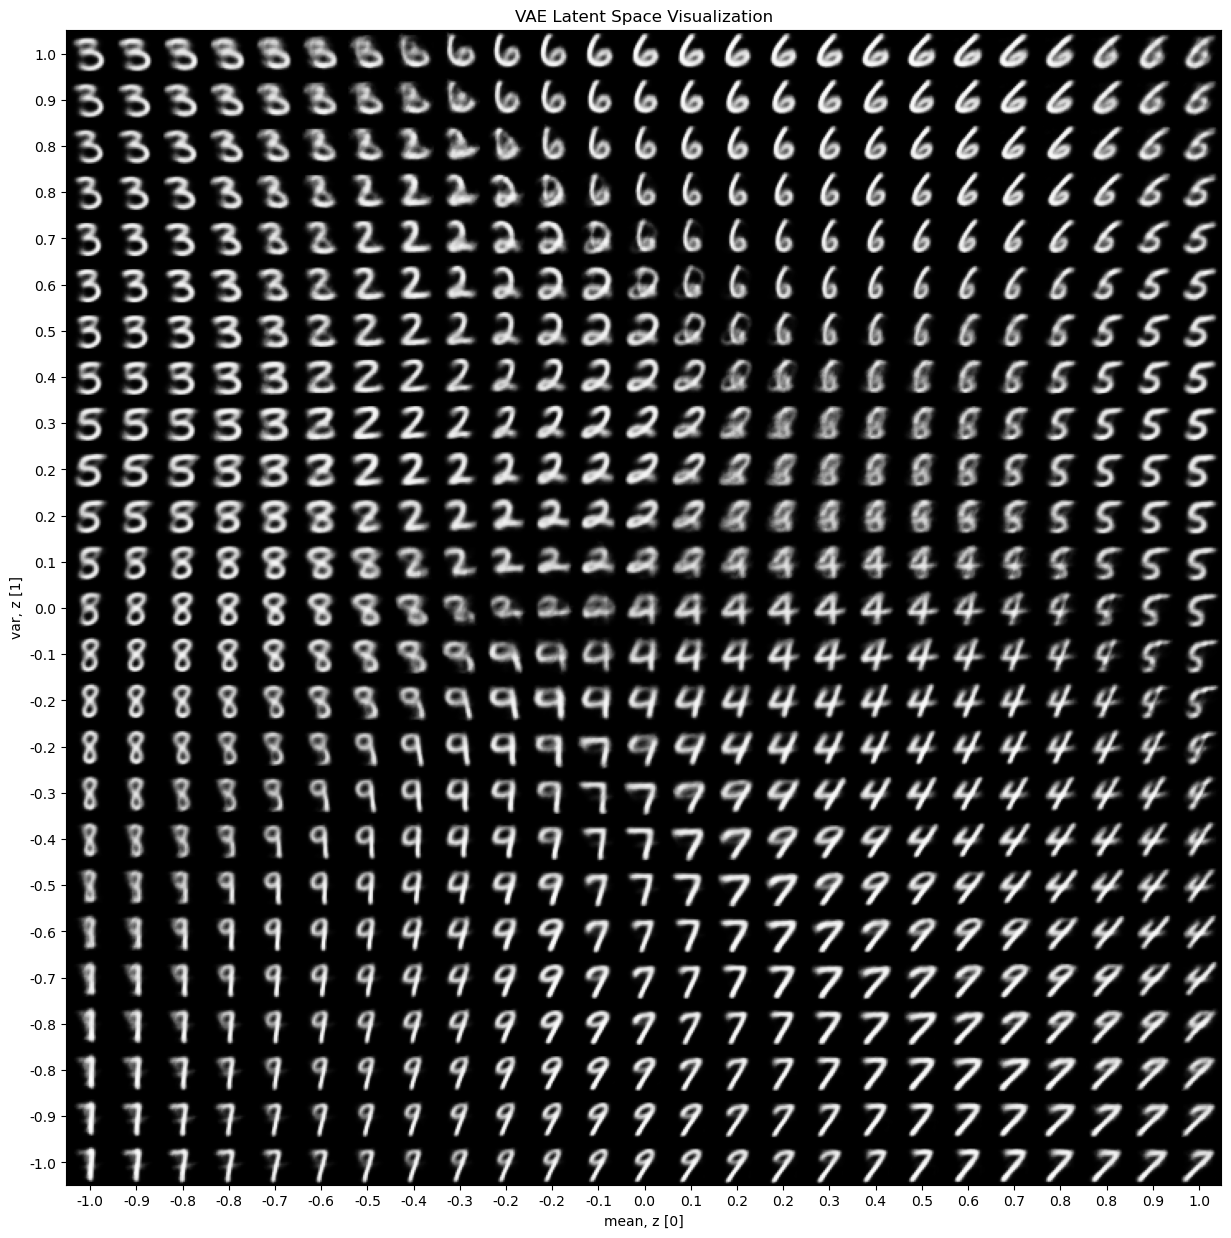

In [20]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title("VAE Latent Space Visualization")
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)